# Feature Engineering 

In [28]:
%reset -f
import pandas as pd
import numpy as np

from xgboost import XGBClassifier
#import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import re, sqlite3, pickle, time, datetime, random, sys
# sys.path is a list of absolute path strings
sys.path.append('/home/d/dlr10/Documents/02_Statitics_modelling/0_FunctionsScripts')
import Loading_Data_Functions as load_fn
import FineTuning_Functions as FineTuning
import Learning_Curves_Functions as LearningCurves

pd.options.display.float_format = '{:,.5f}'.format

import matplotlib
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['mathtext.fontset'] = 'cm'
#matplotlib.rcParams['mathtext.fontset'] = 'cm'

# 0. Load Data
* https://www.reneshbedre.com/blog/anova.html

In [29]:
path = r'/home/d/dlr10/Documents/02_Statitics_modelling/DataSets/'

t = time.time()
timeSeries      = False
peakstroughs    = False
samp_to_extract = 0
df_patients, df_admissions, df_eobs = load_fn.Load_data(years = '2016_2018')
#X_data       = load_fn.Exctract_Xdata(df_patients, df_admissions, df_eobs, samp_to_extract, peakstroughs, timeSeries  )

X_data = pickle.load(open(path + 'df_first_2016_18.pickle','rb'))
print("Elapsed time:", time.time()-t)

Elapsed time: 15.735793113708496


In [30]:
len(X_data['admission_id'])

9390

In [31]:
len(df_admissions[df_admissions['admission_id'].isin(X_data['admission_id'])]['patient_id'].unique())

8243

In [56]:
X_data_v = pickle.load(open(path + 'df_first_2019_20.pickle','rb'))

X_ = X_data.copy()
def summary (X_):
    print('total:', len(X_))
    print('women:', len(X_[X_['sex'] == 1]), len(X_[X_['sex'] == 1])/len(X_) )
    print('mortality:', len(X_[X_['Mortality'] == 1]), len(X_[X_['Mortality'] == 1])/len(X_) )
    print('ethinicity:', len(X_[X_['ethnicity'] == 0]), len(X_[X_['ethnicity'] == 0])/ len(X_))
    X_['age_at_admin'].hist()
    
    q1 = X_['age_at_admin'].quantile(0.25)
    q3 = X_['age_at_admin'].quantile(0.75)
    print('Age Median', X_['age_at_admin'].median(), 'iqr', q1, q3)

    q1 = X_['Comorb_score'].quantile(0.25)
    q3 = X_['Comorb_score'].quantile(0.75)
    print('Charlson Com Median', X_['Comorb_score'].median(), 'iqr', q1, q3)

total: 9390
women: 4553 0.484877529286475
mortality: 2024 0.21554845580404686
ethinicity: 7524 0.8012779552715655
Age Median 78.0 iqr 66.0 85.0
Charlson Com Median 1.0 iqr 0.0 3.0


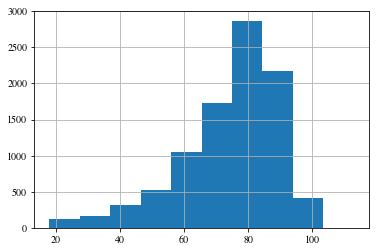

total: 7892
women: 3541 0.44868220983274204
mortality: 1944 0.24632539280283833
ethinicity: 5667 0.718068930562595
Age Median 74.0 iqr 61.0 83.0
Charlson Com Median 2.0 iqr 0.0 3.0


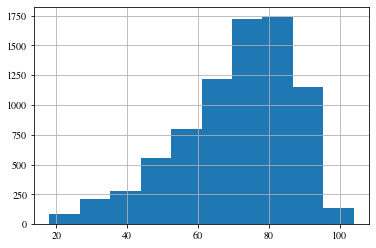

In [57]:
summary(X_data)
plt.show()
print('=========================')
summary(X_data_v)

In [61]:
X_['Assisted_O2'].sum()

9320.0

In [35]:
X_data.head(4)

,admission_id,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,...,ALB,ALP,BILI,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
0,78793793,20.00000,2,98.00000,37.40000,101.00000,40.00000,97.00000,1.00000,1,...,31.00000,103.00000,6.00000,-1,0,88,2,0,0.00000,1
144,30248532,16.00000,0,68.00000,36.50000,157.00000,88.00000,96.00000,1.00000,1,...,40.37500,107.37500,11.93750,1,1,86,1,1,1.00000,0
288,42566860,18.00000,1,87.00000,37.40000,177.00000,87.00000,95.00000,1.00000,1,...,30.00000,69.00000,14.00000,1,1,85,1,0,1.00000,0
432,6483250,22.00000,9,96.00000,36.60000,84.00000,51.00000,94.00000,1.00000,0,...,35.00000,89.00000,16.00000,-1,0,89,3,1,1.00000,0


In [36]:
feat_list = X_data.columns.tolist()
feat_list = feat_list[1:-1]
print(feat_list)
print("Number of features:",len(feat_list))

['rr', 'ews', 'heart_rate', 'temperature', 'sbp', 'dbp', 'Oxygen_Saturation', 'Assisted_O2', 'Confusion', 'CREA', 'UREA', 'K', 'GFR', 'WBC', 'PLT', 'HCT', 'HGB', 'RBC', 'MCH', 'MCV', 'NEUAB', 'TLYMAB', 'EOSAB', 'MONAB', 'BASAB', 'ALB', 'ALP', 'BILI', 'sex', 'ethnicity', 'age_at_admin', 'Comorb_score', 'Spcfc_Comorb', 'had_Prev_admin']
Number of features: 34


In [37]:
# Loading the CSV with types
data_types = pd.read_csv('csv_Type_variables.csv')
# Dictionary of features and types
data_types = data_types.set_index('Variable').to_dict()['Type']

# 1. Multicollinearity
* [Link to the example code](https://towardsdatascience.com/multi-collinearity-in-regression-fe7a2c1467ea)
* [Link to Multi-Collinearity: brief description](https://www.britannica.com/topic/collinearity-statistics)
* [Link to Multicollinearity analysis](https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/)
* [Link to Multicollinearity and LogReg, SVM, and random Forest](https://medium.com/@raj5287/effects-of-multi-collinearity-in-logistic-regression-svm-rf-af6766d91f1b)

In [38]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [39]:
def calc_variance_inflation_factor(X_in,feat_list):
    # VIF dataframe
    X = X_in[feat_list]
    vif_data = pd.DataFrame()
    vif_data["feature"] = feat_list

    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                              for i in range(len(X.columns))]
    print("VARIANCE INFLATION FACTOR TO ASSES MULTICOLLINEARITY")
    display(vif_data.sort_values(by='VIF', ascending=False))
    return (vif_data)

In [40]:
# Measuring multicollinearity using 
# the independent variables set
sel_feat_list = feat_list.copy()
vif_data = calc_variance_inflation_factor(X_data, sel_feat_list)
######
# Removing features with high collinearity to assess its impact
######
sel_feat_list.remove('temperature')
sel_feat_list.remove('Oxygen_Saturation')
sel_feat_list.remove('ews')
sel_feat_list.remove('rr')
sel_feat_list.remove('age_at_admin')
vif_data = calc_variance_inflation_factor(X_data, sel_feat_list)


VARIANCE INFLATION FACTOR TO ASSES MULTICOLLINEARITY


,feature,VIF
15,HCT,"6,870.82289"
19,MCV,"6,826.69943"
16,HGB,"6,266.51857"
18,MCH,"6,189.95566"
3,temperature,"1,330.73453"
17,RBC,"1,226.58990"
6,Oxygen_Saturation,777.51654
7,Assisted_O2,135.13181
25,ALB,67.45141
4,sbp,52.22551


VARIANCE INFLATION FACTOR TO ASSES MULTICOLLINEARITY


,feature,VIF
12,HGB,"6,252.82720"
15,MCV,"6,220.80174"
11,HCT,"6,167.39350"
14,MCH,"6,143.04033"
13,RBC,405.11532
3,Assisted_O2,128.18853
21,ALB,65.47141
1,sbp,45.68735
7,K,45.22255
9,WBC,36.49824


Sholud we normalised encoded data?

[Normalised Encoding Data](https://datascience.stackexchange.com/questions/56142/how-can-i-use-mean-normalization-should-i-use-it-for-numerical-columns-or-categ)

[Encoding Data](https://towardsdatascience.com/categorical-feature-encoding-547707acf4e5#b398)


In [41]:
# Normalise Data
X_data_feat = X_data[feat_list]
X_data_norm = (X_data_feat-X_data_feat.mean())/X_data_feat.std()
X_data_norm.head(4)

,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,CREA,...,BASAB,ALB,ALP,BILI,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin
0,-0.20743,-0.55949,0.34234,0.43203,-1.07120,-2.01254,0.42055,0.08666,0.70910,0.15125,...,-0.74398,-1.25893,-0.18141,-0.76645,-0.97015,-0.40837,0.89352,0.08892,-1.10441,-1.26272
144,-1.01933,-1.22458,-1.08996,-0.58896,1.23578,0.96432,0.14261,0.08666,0.70910,-0.41872,...,-0.39310,0.48745,-0.11959,-0.17987,1.03066,-0.00242,0.76410,-0.47107,0.90536,0.79185
288,-0.61338,-0.89203,-0.18283,0.43203,2.05970,0.90230,-0.13532,0.08666,0.70910,-0.40452,...,-0.83329,-1.44520,-0.66182,0.02389,1.03066,-0.00242,0.69939,-0.47107,-1.10441,0.79185
432,0.19851,1.76834,0.24686,-0.47552,-1.77153,-1.33034,-0.41326,0.08666,-1.41008,0.52279,...,-0.04222,-0.51381,-0.37923,0.22147,-0.97015,-0.40837,0.95822,0.64891,0.90536,0.79185


In [42]:
############################################################
# ENCODING CATEGORICAL VARIABLES WITH TARGET ENCODER
# https://towardsdatascience.com/target-encoding-and-bayesian-target-encoding-5c6a6c58ae8c
############################################################
def target_encoder_Binary(column, target, X_data):
    df = []
    for cat in X_data[column].unique():
        row = []
        row.append(len(X_data[(X_data[target]==0) & (X_data[column] == cat)]))
        row.append(len(X_data[(X_data[target]==1) & (X_data[column] == cat)]))
        df.append(row)
    df = pd.DataFrame(df, index = X_data[column].unique(), columns = ['0','1'])
    df['prob'] = df['1']/(df['1']+df['0'])
    col_encod = X_data[column].map(dict(zip(df.index, df['prob'])))
    return col_encod
############################################################
X_data_norm_2 = pd.DataFrame()
for feat in feat_list:
    if data_types[feat] == 'Continuous':
        X_data_feat = X_data[feat]
        X_data_norm_2[feat] = (X_data_feat-X_data_feat.mean())/X_data_feat.std()
    elif data_types[feat] == 'Categorical':
        X_data_norm_2[feat] = target_encoder_Binary(feat, 'Mortality', X_data)
    elif data_types[feat] == 'Binary':
        X_data_norm_2[feat] = X_data[feat].copy()
        
X_data_norm = X_data_norm_2.copy()
X_data_norm.head(4)


,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,CREA,...,BASAB,ALB,ALP,BILI,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin
0,-0.20743,0.20110,0.34234,0.43203,-1.07120,-2.01254,0.42055,1.00000,1,0.15125,...,-0.74398,-1.25893,-0.18141,-0.76645,-1,0.22209,0.89352,0.08892,0,0.00000
144,-1.01933,0.19987,-1.08996,-0.58896,1.23578,0.96432,0.14261,1.00000,1,-0.41872,...,-0.39310,0.48745,-0.11959,-0.17987,1,0.21239,0.76410,-0.47107,1,1.00000
288,-0.61338,0.20383,-0.18283,0.43203,2.05970,0.90230,-0.13532,1.00000,1,-0.40452,...,-0.83329,-1.44520,-0.66182,0.02389,1,0.21239,0.69939,-0.47107,0,1.00000
432,0.19851,0.22403,0.24686,-0.47552,-1.77153,-1.33034,-0.41326,1.00000,0,0.52279,...,-0.04222,-0.51381,-0.37923,0.22147,-1,0.22209,0.95822,0.64891,1,1.00000


In [43]:
#####################################
# Measuring multicollinearity using 
# the independent variables set
sel_feat_list = feat_list.copy()
vif_data      = calc_variance_inflation_factor(X_data_norm, sel_feat_list)

VARIANCE INFLATION FACTOR TO ASSES MULTICOLLINEARITY


,feature,VIF
15,HCT,198.82474
16,HGB,186.41890
1,ews,99.83042
7,Assisted_O2,96.08528
29,ethnicity,77.15369
18,MCH,63.57496
19,MCV,54.21882
17,RBC,53.65101
13,WBC,7.04614
20,NEUAB,6.60676


# 2. Feature correlation

* Two continuos variables spearman coefficient [-1,1]
* Two Categorical variables Cramer'sV coeeficient [0,1]
* A categorical variable witha  contionuous variables Point biseral correlation [-1,1]

In [44]:
from scipy import stats

In [45]:
########################################################################
# FUNCTION TO DETERMINE THE CORRELATION DEPENDING ON TYPE OF VARIABLES
########################################################################
def correlation_dependednt_type(X_data, feat1, type1, feat2, type2):
    serie1 = X_data[feat1].tolist()
    serie2 = X_data[feat2].tolist()
    type1 = type1 if (type1 == 'Continuous' or type1 == 'Categorical') else 'Categorical'
    type2 = type2 if (type2 == 'Continuous' or type2 == 'Categorical') else 'Categorical'    
    # Spearman correlation for two continuous variables
    if (type1 == 'Continuous') and (type2 == 'Continuous'):
        coef, p = stats.spearmanr(serie1, serie2)
    # Cramer'sV correlation for two categorical variables
    elif (type1 == 'Categorical') and (type2 == 'Categorical'):
        #data = np.array([serie1, serie2])
        df   = pd.DataFrame(zip(serie1, serie2))
        data = np.array(pd.crosstab(df[0],df[1]))
        #Chi-squared test statistic, sample size, and minimum of rows and columns
        X2, p,_,_ = stats.chi2_contingency(data, correction=False)
        n = np.sum(data)
        minDim = min(data.shape)-1
        #calculate Cramer's V 
        coef = np.sqrt((X2/n) / minDim)
    else: # When types are different, Point biserial Correlation
        coef, p = stats.pointbiserialr(np.array(serie1), np.array(serie2))
    return coef, p

In [46]:
########################################################################
# FIND CORRELATION MATRIX
########################################################################
corr = pd.DataFrame(np.zeros((len(feat_list),len(feat_list))), columns = feat_list, index= feat_list)
for idx, feat1 in enumerate(feat_list):
    for feat2 in feat_list[idx:]:
        type1   = data_types[feat1]
        type2   = data_types[feat2]
        if feat1 == feat2:
            corr_ = 1
            p = 0
        else:    
            corr_, p = correlation_dependednt_type(X_data_norm, feat1, type1, feat2, type2)
        corr.at[feat1, feat2] = corr_
        corr.at[feat2, feat1] = corr_
        print(feat1, feat2, p)

rr rr 0
rr ews 1.3893063966063967e-297
rr heart_rate 2.562955256816711e-237
rr temperature 3.758143628773288e-91
rr sbp 0.4351954683761088
rr dbp 0.0008537766003056477
rr Oxygen_Saturation 1.8501434465458603e-106
rr Assisted_O2 0.8639309123012678
rr Confusion 4.873907797478128e-102
rr CREA 0.010482958574514202
rr UREA 9.168469612192075e-05
rr K 2.140905848398588e-10
rr GFR 5.9670377505923266e-05
rr WBC 1.9017801592420966e-43
rr PLT 2.988362970623079e-08
rr HCT 7.106803627086645e-35
rr HGB 5.808882842950146e-25
rr RBC 2.7283937541801532e-33
rr MCH 0.02814967821971936
rr MCV 0.28718095266008037
rr NEUAB 5.7216440271748346e-49
rr TLYMAB 2.787854825350025e-10
rr EOSAB 1.6185194426433773e-05
rr MONAB 4.664560593217926e-08
rr BASAB 7.0396237341240066e-09
rr ALB 5.825436092826462e-29
rr ALP 0.00020550303611724423
rr BILI 1.565182123211278e-06
rr sex 0.2759512426223868
rr ethnicity 0.655933768208262
rr age_at_admin 4.966913694389364e-11
rr Comorb_score 0.0720981950399184
rr Spcfc_Comorb 1.5261

Assisted_O2 Comorb_score 0.6812246066425259
Assisted_O2 Spcfc_Comorb 0.39419495830743545
Assisted_O2 had_Prev_admin 0.049209636141833546
Confusion Confusion 0
Confusion CREA 0.8365482487567562
Confusion UREA 6.027932679093248e-06
Confusion K 0.05745324725280324
Confusion GFR 1.3758524487538088e-05
Confusion WBC 2.109000145443535e-12
Confusion PLT 0.3045291691061776
Confusion HCT 3.151804224600551e-11
Confusion HGB 0.00010585446573781877
Confusion RBC 2.0717199836659315e-06
Confusion MCH 0.22182885419565324
Confusion MCV 0.003033391795868241
Confusion NEUAB 3.303504822814168e-20
Confusion TLYMAB 6.677896918272822e-12
Confusion EOSAB 1.2518291373481955e-06
Confusion MONAB 0.5648570363807922
Confusion BASAB 0.00018997978385006792
Confusion ALB 0.18395690109903978
Confusion ALP 0.12022653292820945
Confusion BILI 0.3976283362637675
Confusion sex 5.900647242557302e-06
Confusion ethnicity 1.437570573529554e-07
Confusion age_at_admin 3.5236679793567123e-12
Confusion Comorb_score 0.170530572810

BASAB ethnicity 0.18595568855016167
BASAB age_at_admin 5.963231294952167e-16
BASAB Comorb_score 0.011611965984923875
BASAB Spcfc_Comorb 0.356375963964796
BASAB had_Prev_admin 0.053218811478380715
ALB ALB 0
ALB ALP 7.323879696432482e-20
ALB BILI 0.06071373933174915
ALB sex 1.3821264216199621e-09
ALB ethnicity 0.022806718638137696
ALB age_at_admin 3.670863628944412e-10
ALB Comorb_score 1.4814287014881836e-24
ALB Spcfc_Comorb 0.00020650284896211156
ALB had_Prev_admin 8.094656920469951e-22
ALP ALP 0
ALP BILI 9.289702289917437e-05
ALP sex 0.6797675796302254
ALP ethnicity 0.29122266720232726
ALP age_at_admin 0.9098722766897758
ALP Comorb_score 1.981262286928416e-20
ALP Spcfc_Comorb 1.4516200819273876e-07
ALP had_Prev_admin 6.558758850358657e-09
BILI BILI 0
BILI sex 1.3974406342765524e-32
BILI ethnicity 0.432640390711551
BILI age_at_admin 0.0117591452723829
BILI Comorb_score 0.010299367902711618
BILI Spcfc_Comorb 7.598409461956608e-12
BILI had_Prev_admin 3.219937471396623e-06
sex sex 0
sex et

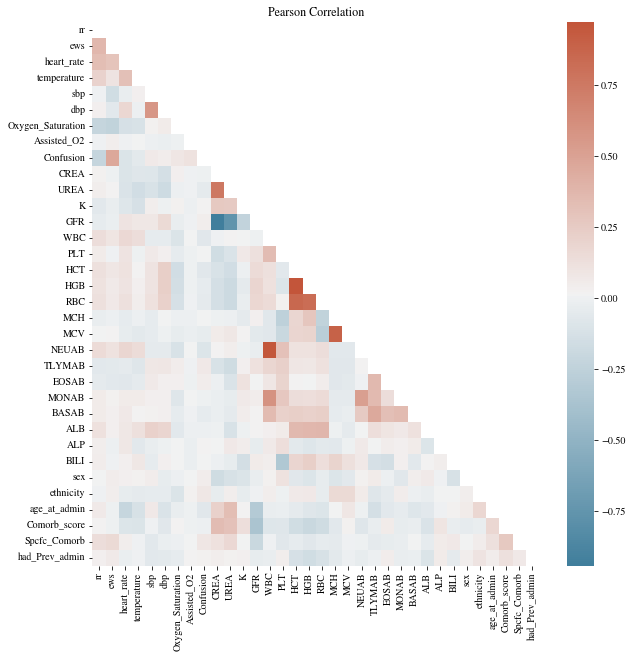

In [47]:
########################################################################
# PLOT CORRELATION MATRIX
########################################################################
f, ax = plt.subplots(figsize=(10, 10))
# Generate a mask for upper traingle#
mask = np.triu(np.ones_like(corr, dtype=bool))
#import matplotlib
#matplotlib.rcParams['mathtext.fontset'] = 'cm'
# Configure a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap
sns.heatmap(corr, mask = mask, cmap=cmap)
plt.savefig('Pearson Correlation_STA.png', transparent = True, bbox_inches = "tight")
plt.title('Pearson Correlation')
plt.show()

# 3. Logistic Regression to asses significance

### Data to process

In [48]:
X_data_norm.head(5)
df_results = pd.DataFrame()

### 3.1 Individual variable significance

In [49]:
from scipy import stats
from statsmodels.stats.weightstats import ztest as ztest
from scipy.stats import chi2_contingency


In [51]:
########################################################################
# VARIABLE INDIVIDUAL SIGNIFICANCE
########################################################################
p_norm_test = []
idx_0 = X_data[X_data['Mortality'] == 0].index
idx_1 = X_data[X_data['Mortality'] == 1].index
for idx, feat1 in enumerate(feat_list):
    p = ''
    x_0 = X_data_norm.loc[idx_0][feat1]
    x_1 = X_data_norm.loc[idx_1][feat1]
    type1  = data_types[feat1]
    
    if (type1 == 'Continuous') :
            sts, p = stats.ttest_ind(x_0, x_1)
    elif (type1 == 'Binary'):        
        sts, p1 = ztest(x_0, x_1, value=0) 
        contigency = pd.crosstab(index=X_data['Mortality'], columns=X_data[feat1], margins=True)
        contigency = contigency.drop(columns=['All'], index =['All'])
        c, p, dof, expected = chi2_contingency(contigency)
        print(feat1, '{:3f}'.format(p), '{:3f}'.format(p1))
    elif (type1 == 'Categorical'):
        sts, p = stats.kruskal(x_0, x_1)
        print(feat1, '{:3f}'.format(p))
        
    p_norm_test.append(p)

rr 0.700724 0.041461
ews 0.000056
Assisted_O2 0.481681 0.395646
Confusion 0.036851 0.034491
sex 0.000000 0.000000
ethnicity 0.000042
Spcfc_Comorb 0.000000 0.000000
had_Prev_admin 0.000000 0.000000


In [ ]:
########################################################################
# RESULTS
########################################################################
df_results['type'] = [data_types[feat1] for feat1 in feat_list]
df_results['pval_Indiv'] = p_norm_test
df_results = df_results.set_index([feat_list])
display(df_results)

### 3.2 Multivariate Logistic Regression

In [21]:
import statsmodels.api as sm

In [22]:
X_train = X_data_norm
y_train = X_data['Mortality']
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.447428
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              Mortality   No. Observations:                 9390
Model:                          Logit   Df Residuals:                     9356
Method:                           MLE   Df Model:                           33
Date:                Thu, 20 Jul 2023   Pseudo R-squ.:                  0.1416
Time:                        13:50:32   Log-Likelihood:                -4201.3
converged:                       True   LL-Null:                       -4894.2
Covariance Type:            nonrobust   LLR p-value:                2.596e-270
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
rr                    0.0636      0.031      2.059      0.040       0.003       0.124
ews     

In [23]:
df_results['pval_logR'] = result.pvalues.tolist()
df_results['coef_logR'] = result.params.tolist()

### 3.3 Lasso Regression Original Data

In [24]:
X_data[feat_list].head(3)

,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,CREA,...,BASAB,ALB,ALP,BILI,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin
0,20.00000,2,98.00000,37.40000,101.00000,40.00000,97.00000,1.00000,1,129.00000,...,0.01500,31.00000,103.00000,6.00000,-1,0,88,2,0,0.00000
144,16.00000,0,68.00000,36.50000,157.00000,88.00000,96.00000,1.00000,1,78.37500,...,0.02750,40.37500,107.37500,11.93750,1,1,86,1,1,1.00000
288,18.00000,1,87.00000,37.40000,177.00000,87.00000,95.00000,1.00000,1,79.63636,...,0.01182,30.00000,69.00000,14.00000,1,1,85,1,0,1.00000


In [25]:
import regressors
from sklearn.linear_model import LassoCV
from regressors import stats

In [26]:
X_train = X_data[feat_list]
y_train = X_data['Mortality']

In [27]:
lasso_reg = LassoCV(cv = 5)
lasso_reg.fit(X_train, y_train)

regressors.stats.summary(lasso_reg, X_train, y_train)

Residuals:
     Min      1Q  Median      3Q     Max
-0.27450 0.11880 0.21260 0.31100 0.91830


Coefficients:
            Estimate  Std. Error   t value  p value
_intercept   1.03890     0.29234   3.55380  0.00038
x1           0.00097     0.00099   0.98350  0.32540
x2           0.00299     0.00216   1.38360  0.16651
x3           0.00035     0.00020   1.75860  0.07868
x4          -0.03390     0.00319 -10.61140  0.00000
x5          -0.00063     0.00018  -3.50790  0.00045
x6           0.00122     0.00030   4.01090  0.00006
x7           0.00112     0.00075   1.49860  0.13402
x8          -0.00000     0.04607  -0.00000  1.00000
x9           0.00000     0.00944   0.00000  1.00000
x10         -0.00018     0.00005  -3.56300  0.00037
x11          0.01092     0.00103  10.58760  0.00000
x12          0.00000     0.00605   0.00000  1.00000
x13          0.00146     0.00026   5.56630  0.00000
x14         -0.00191     0.00128  -1.49350  0.13535
x15          0.00008     0.00003   3.02670  0.00248
x16    

In [28]:
p_vals_lasso = list(regressors.stats.coef_pval(lasso_reg, X_train, y_train))[1:]
df_results['pval_Lasso_org'] = p_vals_lasso

### 3.4 Lasso Regression Normalised Data

In [29]:
X_train = X_data[feat_list]
y_train = X_data['Mortality']

In [30]:
lasso_reg_norm = LassoCV(cv = 5)
lasso_reg_norm.fit(X_train, y_train)

regressors.stats.summary(lasso_reg_norm, X_train, y_train)

Residuals:
     Min      1Q  Median      3Q     Max
-0.27450 0.11880 0.21260 0.31100 0.91830


Coefficients:
            Estimate  Std. Error   t value  p value
_intercept   1.03890     0.29234   3.55380  0.00038
x1           0.00097     0.00099   0.98350  0.32540
x2           0.00299     0.00216   1.38360  0.16651
x3           0.00035     0.00020   1.75860  0.07868
x4          -0.03390     0.00319 -10.61140  0.00000
x5          -0.00063     0.00018  -3.50790  0.00045
x6           0.00122     0.00030   4.01090  0.00006
x7           0.00112     0.00075   1.49860  0.13402
x8          -0.00000     0.04607  -0.00000  1.00000
x9           0.00000     0.00944   0.00000  1.00000
x10         -0.00018     0.00005  -3.56300  0.00037
x11          0.01092     0.00103  10.58760  0.00000
x12          0.00000     0.00605   0.00000  1.00000
x13          0.00146     0.00026   5.56630  0.00000
x14         -0.00191     0.00128  -1.49350  0.13535
x15          0.00008     0.00003   3.02670  0.00248
x16    

In [31]:
p_vals_lasso_norm = list(regressors.stats.coef_pval(lasso_reg_norm, X_train, y_train))[1:]
df_results['pval_Lasso_norm'] = p_vals_lasso_norm

In [32]:
regressors.stats.coef_se(lasso_reg_norm, X_train, y_train)

array([2.92336494e-01, 9.90205559e-04, 2.16021287e-03, 1.97108009e-04,
       3.19433582e-03, 1.79733209e-04, 3.04099494e-04, 7.48566793e-04,
       4.60685589e-02, 9.44420695e-03, 5.10328727e-05, 1.03172334e-03,
       6.05047268e-03, 2.62893627e-04, 1.28022604e-03, 2.76719278e-05,
       9.04963898e-01, 2.37809156e-04, 3.25636643e-02, 4.13798555e-03,
       8.02734799e-04, 1.84231195e-03, 5.99625864e-03, 2.98771719e-02,
       1.54884015e-02, 1.32733743e-01, 8.15136702e-04, 5.47665632e-05,
       4.31673620e-04, 4.29704323e-03, 1.65235514e-03, 2.60557816e-04,
       2.42650814e-03, 8.50391647e-03, 8.36219967e-03])

### 3.5 Ridge Linear Regression

In [33]:
from sklearn.linear_model import RidgeCV
from regressors import stats

In [34]:
X_train = X_data_norm
y_train = X_data['Mortality']

In [35]:
rr_scaled = RidgeCV(cv =5)
rr_scaled.fit(X_train, y_train)

regressors.stats.summary(rr_scaled, X_train, y_train)

Residuals:
     Min      1Q  Median      3Q     Max
-0.28740 0.11330 0.21290 0.31690 0.91070


Coefficients:
            Estimate  Std. Error   t value  p value
_intercept  -0.08225     0.05015  -1.64010  0.10102
x1           0.00532     0.00434   1.22480  0.22067
x2           0.92858     0.23116   4.01700  0.00006
x3           0.00742     0.00452   1.64340  0.10033
x4          -0.03456     0.00430  -8.02910  0.00000
x5          -0.01241     0.00482  -2.57450  0.01005
x6           0.01824     0.00490   3.72630  0.00019
x7           0.00718     0.00411   1.74760  0.08057
x8          -0.03389     0.03578  -0.94720  0.34357
x9           0.01211     0.00827   1.46460  0.14306
x10         -0.01843     0.00653  -2.82290  0.00477
x11          0.06578     0.00619  10.63020  0.00000
x12          0.00320     0.00422   0.75840  0.44826
x13          0.03443     0.00691   4.98130  0.00000
x14         -0.01261     0.00891  -1.41530  0.15703
x15          0.01147     0.00457   2.51110  0.01205
x16    

In [36]:
p_vals_ridge = list(regressors.stats.coef_pval(rr_scaled, X_train, y_train))[1:]
df_results['pval_Ridge'] = p_vals_ridge

# # DISPLAY RESULTS
###########################################
#display(df_results)
df_results = df_results.copy()
df_results['idx'] = feat_list
df_results = df_results.set_index('idx')
df_results['LogR_sig'] = df_results['pval_logR'].apply(lambda x: 0 if x > 0.099 else 0.5 if x > 0.05 else 1)
df_results

In [37]:
########################################### 
display(df_results) 
df_results = df_results.copy() 
df_results['idx'] = feat_list 
df_results = df_results.set_index('idx') 
df_results['LogR_sig'] = df_results['pval_logR'].apply(lambda x: 0 if x > 0.099 else 0.5 if x > 0.05 else 1) 
df_results

,type,pval_Indiv,pval_logR,coef_logR,pval_Lasso_org,pval_Lasso_norm,pval_Ridge
rr,Continuous,0.04149,0.03951,0.06356,0.32540,0.32540,0.22067
ews,Categorical,0.00006,0.43615,-0.95694,0.16651,0.16651,0.00006
heart_rate,Continuous,0.01755,0.01404,0.07833,0.07868,0.07868,0.10033
temperature,Continuous,0.00000,0.00000,-0.24962,0.00000,0.00000,0.00000
sbp,Continuous,0.00000,0.00732,-0.09477,0.00045,0.00045,0.01005
dbp,Continuous,0.05629,0.00091,0.11716,0.00006,0.00006,0.00020
Oxygen_Saturation,Continuous,0.39851,0.84311,-0.00558,0.13402,0.13402,0.08057
Assisted_O2,Binary,0.48168,0.00000,-1.14113,1.00000,1.00000,0.34356
Confusion,Binary,0.03685,0.60258,-0.03142,1.00000,1.00000,0.14306
CREA,Continuous,0.00000,0.09163,-0.08020,0.00037,0.00037,0.00477


,type,pval_Indiv,pval_logR,coef_logR,pval_Lasso_org,pval_Lasso_norm,pval_Ridge,LogR_sig
idx,,,,,,,,
rr,Continuous,0.04149,0.03951,0.06356,0.32540,0.32540,0.22067,1.00000
ews,Categorical,0.00006,0.43615,-0.95694,0.16651,0.16651,0.00006,0.00000
heart_rate,Continuous,0.01755,0.01404,0.07833,0.07868,0.07868,0.10033,1.00000
temperature,Continuous,0.00000,0.00000,-0.24962,0.00000,0.00000,0.00000,1.00000
sbp,Continuous,0.00000,0.00732,-0.09477,0.00045,0.00045,0.01005,1.00000
dbp,Continuous,0.05629,0.00091,0.11716,0.00006,0.00006,0.00020,1.00000
Oxygen_Saturation,Continuous,0.39851,0.84311,-0.00558,0.13402,0.13402,0.08057,0.00000
Assisted_O2,Binary,0.48168,0.00000,-1.14113,1.00000,1.00000,0.34356,1.00000
Confusion,Binary,0.03685,0.60258,-0.03142,1.00000,1.00000,0.14306,0.00000


In [38]:
dict_labels = {'rr':'Respiratory rate','ews':'EWS','heart_rate':'Heart rate','temperature':'Temperature',
               'sbp':'Systolic bp','dbp':'Diastolic bp','Oxygen_Saturation':'Oxygen Saturation','Assisted_O2':'Assisted O2',
               'Confusion':'Confusion','CREA':'Creatinine','UREA':'Urea','K':'Potassium', 'GFR':'GFR','WBC':'WBC',
               'PLT':'Platelets','HCT':'HCT','HGB':'Haemoglobin','RBC':'RBC','MCH':'MCH','MCV':'MCV','NEUAB':'Neutrophil Ab',
               'TLYMAB':'T-lymphocite Ab','EOSAB':'EOS Ab','MONAB':'Monocyte Ab','BASAB':'Anti Basophil Ab','ALB':'Albumin',
               'ALP':'Alk. Phosphate','BILI':'Bilirubin','sex':'Sex','ethnicity':'Ethnicity','had_Prev_admin':'Prev. admission',
               'age_at_admin':'Age at admission','Comorb_score':'Charlson comorbid.','Spcfc_Comorb':'Resp. Comorbidity'}

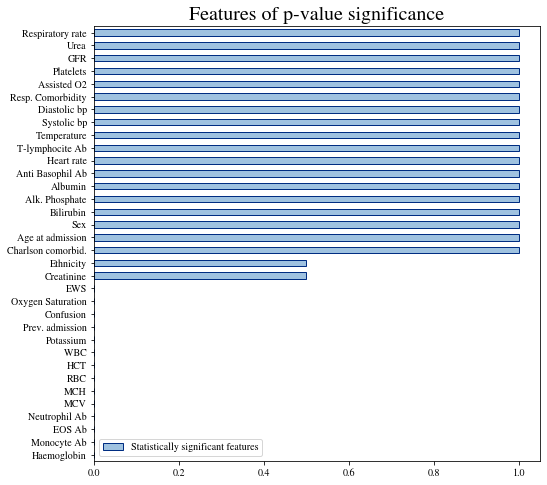

In [39]:
matplotlib.rcParams['mathtext.fontset'] = 'cm'
df_results['LogR_sig'].sort_values(ascending = True).plot.barh(figsize=(8, 8), edgecolor='#002D82', color='#9fc2e0',
                                                               label = "Statistically significant features")
plt.legend()
plt.ylabel('')
ordered_label = [dict_labels[feat] for feat in df_results['LogR_sig'].sort_values(ascending = True).index]
plt.yticks(range(len(df_results['LogR_sig'].index.tolist())), ordered_label)

plt.title('Features of p-value significance', fontsize = 20)
#plt.savefig('Feature_selection_STA.png', transparent = True, bbox_inches = "tight")
plt.show()

# _______________________________________

# 4. Feature Importance

#### Using Random Forrest, Decision Trees and XGBoost models
[Explanation of importance calculus](https://towardsdatascience.com/the-mathematics-of-decision-trees-random-forest-and-feature-importance-in-scikit-learn-and-spark-f2861df67e3)

In [40]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import svm

In [41]:
X_train = X_data_norm
y_train = X_data['Mortality']

In [42]:
row = []

y = np.array(X_data['Mortality'])
#X = np.array(X_data_norm)
X = X_data[feat_list]
#model = DecisionTreeRegressor()
#model = RandomForestRegressor()

# fit the model DTree
model_DTree  = DecisionTreeRegressor()
model_DTree.fit(X, y)
import_DTree = model_DTree.feature_importances_

# fit the model RFor
model_RFor  = RandomForestRegressor()
model_RFor.fit(X, y)
import_RFor = model_RFor.feature_importances_

# fit the model XGB
model_XGB  =  XGBRegressor()
model_XGB.fit(X, y)
import_XGB = model_XGB.feature_importances_

for i,v in enumerate(import_DTree):
    row.append((v, import_RFor[i], import_XGB[i]))
row = pd.DataFrame(row, columns = ['import_DT', 'import_RF', 'import_XGB'], index = feat_list)
display(row)

,import_DT,import_RF,import_XGB
rr,0.02592,0.02686,0.01190
ews,0.01623,0.01687,0.01216
heart_rate,0.02870,0.03367,0.01861
temperature,0.03528,0.03693,0.02765
sbp,0.03289,0.03687,0.01898
dbp,0.03282,0.03115,0.02410
Oxygen_Saturation,0.02552,0.02415,0.02493
Assisted_O2,0.00116,0.00111,0.01995
Confusion,0.00496,0.00335,0.01587
CREA,0.02732,0.03463,0.02416


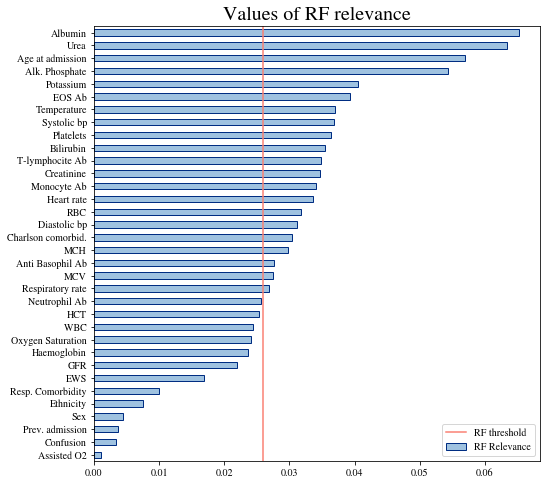

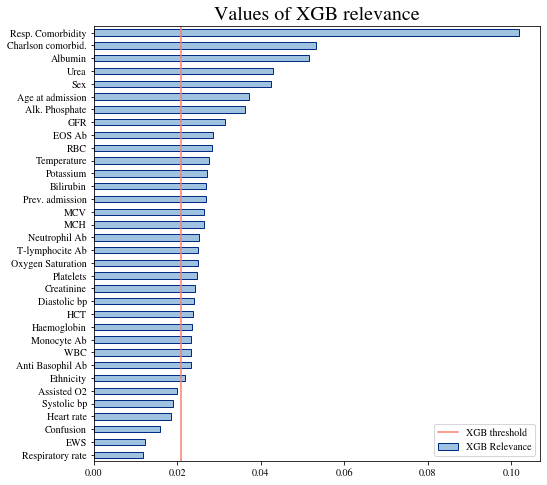

In [43]:
#row['import_DT'].sort_values(ascending = True).plot.barh(figsize=(8, 10))
#plt.axvline(x = 0.026, color = 'r', linestyle = '-')
#plt.savefig('Feature_selection_DT.png', transparent = True, bbox_inches = "tight")
#plt.show()
matplotlib.rcParams['mathtext.fontset'] = 'cm'
row['import_RF'].sort_values(ascending = True).plot.barh(figsize=(8, 8), label = "RF Relevance", color='#9fc2e0', 
                                                         edgecolor='#002D82')
ordered_label = [dict_labels[feat] for feat in row['import_RF'].sort_values(ascending = True).index]

plt.axvline(x = 0.026, linestyle = '-', label = "RF threshold", color = '#FA8072')
plt.legend()
plt.yticks(range(len(row['import_RF'].sort_values(ascending = True).index)), ordered_label)
plt.title('Values of RF relevance', fontsize = 20)
plt.savefig('Feature_selection_RF.png', transparent = True, bbox_inches = "tight")
plt.show()

row['import_XGB'].sort_values(ascending = True).plot.barh(figsize=(8, 8), label = "XGB Relevance", color='#9fc2e0', 
                                                          edgecolor='#002D82')
ordered_label = [dict_labels[feat] for feat in row['import_XGB'].sort_values(ascending = True).index]
plt.yticks(range(len(row['import_RF'].index)), ordered_label)
plt.axvline(x = 0.021, linestyle = '-', label = "XGB threshold", color = '#FA8072')
plt.legend()
plt.title('Values of XGB relevance', fontsize = 20)
plt.savefig('Feature_selection_XGB.png', transparent = True, bbox_inches = "tight")
plt.show()

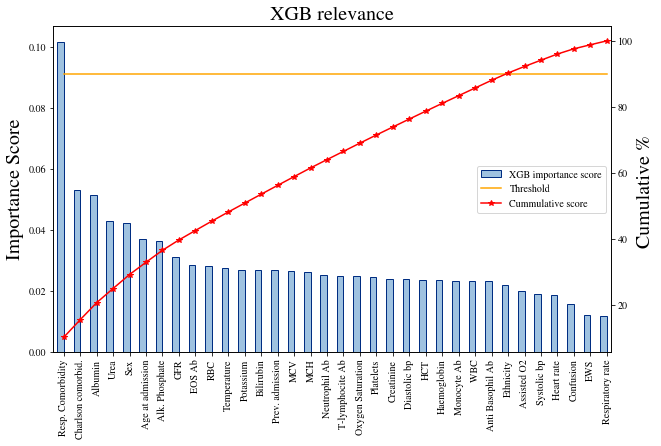

In [44]:

df_ordered = row['import_XGB'].sort_values(ascending = False).to_frame()
df_ordered['accum_per'] = 100*(df_ordered.cumsum() / df_ordered.sum())
fig = plt.figure(figsize = (10,6)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['mathtext.fontset'] = 'cm'
#

width = 0.4
ax2.plot(range(len(df_ordered['import_XGB'])), len(df_ordered['import_XGB'])*[90], color = '#FFA500', label = 'Threshold')
df_ordered['import_XGB'].plot.bar(label = "XGB importance score", color='#9fc2e0', edgecolor='#002D82',
                                  ax=ax, width=width, position=1)
df_ordered['accum_per'].plot( label = "Cummulative score", color= 'r', marker ='*', ax=ax2)

ordered_label = [dict_labels[feat] for feat in row['import_XGB'].sort_values(ascending = False).index]
plt.xticks(range(len(ordered_label)), ordered_label)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc= 'center right')
plt.title(r'XGB relevance', fontsize = 20)
ax.set_ylabel('Importance Score', fontsize = 20)
ax2.set_ylabel('Cumulative % ', fontsize = 20)
plt.xticks(range(len(ordered_label)), ordered_label)
plt.savefig('Feature_selection_XGB_2.png', transparent = True, bbox_inches = "tight")
plt.show()

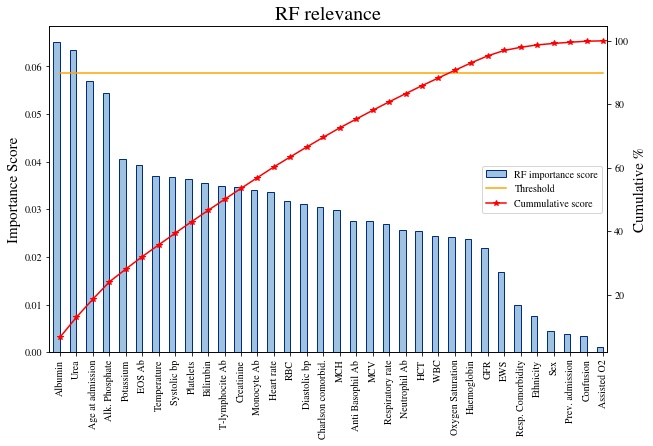

In [45]:
df_ordered = row['import_RF'].sort_values(ascending = False).to_frame()
df_ordered['accum_per'] = 100*(df_ordered.cumsum() / df_ordered.sum())

fig = plt.figure(figsize = (10,6)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4
ax2.plot(range(len(df_ordered['import_RF'])), len(df_ordered['import_RF'])*[90], color = '#FFA500', label = 'Threshold')
df_ordered['import_RF'].plot.bar(label = "RF importance score", color='#9fc2e0', edgecolor='#002D82',
                                  ax=ax, width=width, position=1)
df_ordered['accum_per'].plot( label = "Cummulative score", color= 'r', marker ='*', ax=ax2)

ordered_label = [dict_labels[feat] for feat in row['import_RF'].sort_values(ascending = False).index]
plt.xticks(range(len(ordered_label)), ordered_label)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc= 'center right')
plt.title('RF relevance', fontsize = 20)
ax.set_ylabel('Importance Score', fontsize = 15)
ax2.set_ylabel('Cumulative %', fontsize = 15)
plt.savefig('Feature_selection_RF_2.png', transparent = True, bbox_inches = "tight")
plt.show()

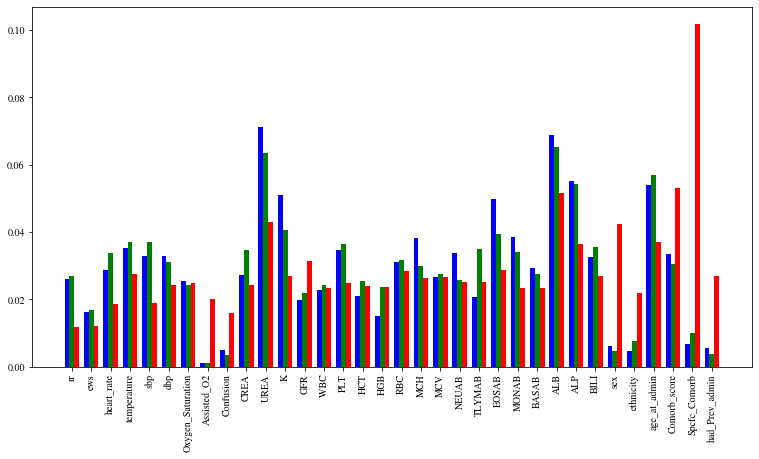

In [46]:

X = np.arange(len(feat_list))

fig = plt.figure(figsize = (10,5))
ax  = fig.add_axes([0,0,1,1])


ax.bar(X - 0.25, row['import_DT'],  color = 'b', width = 0.25, label ='DT')
ax.bar(X + 0.00, row['import_RF'],  color = 'g', width = 0.25, label='RF')
ax.bar(X + 0.25, row['import_XGB'], color = 'r', width = 0.25, label = 'XGB')

ax.set_xticks(np.arange(len(feat_list)))
ax.set_xticklabels(feat_list, rotation = 90)
plt.savefig('Feature_selection_16_18.png', transparent = True, bbox_inches = "tight")
plt.show()

# Description of Variables

In [47]:
import math 
print('Continuous variables')
df_descrip    = []
idx_cont_cols = [i for i, name in enumerate(feat_list) if data_types[name] == 'Continuous']
X = np.asarray(X_data[X_data['Mortality']==0][feat_list])

for idx in idx_cont_cols:
    m      = X[:, idx].mean()
    s      = X[:, idx].std()
    ci95   = ['{:.2f}'.format(m - 1.95*s/math.sqrt(len(X))),'{:.2f}'.format(m + 1.95*s/math.sqrt(len(X)))]
    mm_rng = ['{:.2f}'.format(X[:, idx].min()), '{:.2f}'.format(X[:,idx].max())]
    row    = [feat_list[idx]] + ['{:.2f}'.format(m), '{:.2f}'.format(s), '{:.2f}'.format(np.median(X[:, idx]))
                                  , ci95, mm_rng]
    df_descrip.append(row)  
    
df_descrip_0 = pd.DataFrame (df_descrip, columns = ['variable','mean', 'st_dev', 'median', 'conf-int', 'Min-Max rng'])
display(df_descrip_0)

#___________________________________________________________________________________________________
#___________________________________________________________________________________________________
df_descrip    = []
X = np.asarray(X_data[X_data['Mortality']==1][feat_list])

for idx in idx_cont_cols:
    m      = X[:, idx].mean()
    s      = X[:, idx].std()
    ci95   = ['{:.2f}'.format(m - 1.95*s/math.sqrt(len(X))),'{:.2f}'.format(m + 1.95*s/math.sqrt(len(X)))]
    mm_rng = ['{:.2f}'.format(X[:, idx].min()), '{:.2f}'.format(X[:,idx].max())]
    row    = [feat_list[idx]] + ['{:.2f}'.format(m), '{:.2f}'.format(s), '{:.2f}'.format(np.median(X[:, idx]))
                                  , ci95, mm_rng]
    df_descrip.append(row)  
    
df_descrip_1 = pd.DataFrame (df_descrip, columns = ['variable','mean', 'st_dev', 'median', 'conf-int', 'Min-Max rng'])
display(df_descrip_1)

Continuous variables


,variable,mean,st_dev,median,conf-int,Min-Max rng
0,rr,20.97,4.89,20.00,"[20.86, 21.08]","[5.00, 40.00]"
1,heart_rate,91.10,20.93,89.00,"[90.62, 91.57]","[20.00, 160.00]"
2,temperature,37.09,0.89,37.00,"[37.07, 37.11]","[30.00, 40.80]"
3,sbp,127.65,24.07,126.00,"[127.11, 128.20]","[60.00, 200.00]"
4,dbp,72.62,16.04,71.00,"[72.25, 72.98]","[40.00, 120.00]"
5,Oxygen_Saturation,95.47,3.53,96.00,"[95.39, 95.55]","[60.00, 100.00]"
6,CREA,112.37,86.71,86.69,"[110.40, 114.34]","[20.00, 600.00]"
7,UREA,9.03,5.85,7.28,"[8.90, 9.16]","[1.30, 30.00]"
8,K,4.29,0.68,4.22,"[4.28, 4.31]","[2.20, 7.00]"
9,GFR,65.01,23.39,69.00,"[64.48, 65.55]","[20.00, 128.50]"


,variable,mean,st_dev,median,conf-int,Min-Max rng
0,rr,21.22,5.07,20.00,"[21.00, 21.44]","[5.00, 40.00]"
1,heart_rate,89.85,20.98,88.00,"[88.94, 90.76]","[28.00, 160.00]"
2,temperature,36.77,0.80,36.70,"[36.74, 36.81]","[30.00, 39.50]"
3,sbp,124.63,24.85,122.00,"[123.55, 125.71]","[62.00, 200.00]"
4,dbp,71.85,16.42,70.00,"[71.13, 72.56]","[40.00, 120.00]"
5,Oxygen_Saturation,95.55,3.82,96.00,"[95.38, 95.71]","[68.00, 100.00]"
6,CREA,127.21,95.17,99.00,"[123.08, 131.33]","[22.00, 600.00]"
7,UREA,11.73,7.03,9.65,"[11.42, 12.03]","[1.40, 30.00]"
8,K,4.38,0.77,4.31,"[4.35, 4.42]","[2.30, 7.00]"
9,GFR,59.41,24.86,59.74,"[58.33, 60.49]","[20.00, 118.00]"


In [48]:
import math 
print('Binary variables')
df_descrip    = []
idx_cont_cols = [i for i, name in enumerate(feat_list) if data_types[name] == 'Binary']
#X = np.asarray(X_data[X_data['Mortality']==0][feat_list])
X = X_data[X_data['Mortality']==0][feat_list]

for idx in idx_cont_cols:
    name    = feat_list[idx]
    count_1 = len(X[X[name]==1])
    percent = 100* count_1/len(X[name])
    row = [feat_list[idx], count_1, '{:.2f}'.format( percent)]
    df_descrip.append(row)  
    
df_descrip = pd.DataFrame (df_descrip, columns = ['variable','count', 'percent'])
display(df_descrip)

#___________________________________________________________________________________________________
#___________________________________________________________________________________________________


df_descrip_1   = []
#X = np.asarray(X_data[X_data['Mortality']==0][feat_list])
X = X_data[X_data['Mortality']==1][feat_list]

for idx in idx_cont_cols:
    name    = feat_list[idx]
    count_1 = len(X[X[name]==1])
    percent = 100* count_1/len(X[name])
    row = [feat_list[idx], count_1, '{:.2f}'.format( percent)]
    df_descrip_1.append(row)  
    
df_descrip_1 = pd.DataFrame (df_descrip_1, columns = ['variable','count', 'percent'])
display(df_descrip_1)

Binary variables


,variable,count,percent
0,Assisted_O2,7314,99.29
1,Confusion,4941,67.08
2,sex,3676,49.90
3,Spcfc_Comorb,3769,51.17
4,had_Prev_admin,4413,59.91


,variable,count,percent
0,Assisted_O2,2006,99.11
1,Confusion,1307,64.58
2,sex,877,43.33
3,Spcfc_Comorb,1391,68.73
4,had_Prev_admin,1358,67.09


In [49]:
import math 
print('Categorical variables')
df_descrip    = []
idx_cont_cols = [i for i, name in enumerate(feat_list) if data_types[name] == 'Categorical']
#X = np.asarray(X_data[X_data['Mortality']==0][feat_list])
X = np.asarray(X_data[X_data['Mortality']==0][feat_list])

for idx in idx_cont_cols:
    name    = feat_list[idx]
    median  = np.median(X[:, idx])
    iqr     = np.percentile(X[:, idx], [75 ,25])
    row = [feat_list[idx], median, iqr]
    df_descrip.append(row)  
    
df_descrip = pd.DataFrame (df_descrip, columns = ['variable','median', 'iqr'])
display(df_descrip)

#___________________________________________________________________________________________________
#___________________________________________________________________________________________________


df_descrip_1   = []
#X = np.asarray(X_data[X_data['Mortality']==0][feat_list])
X = np.asarray(X_data[X_data['Mortality']==1][feat_list])

for idx in idx_cont_cols:
    name    = feat_list[idx]
    median  = np.median(X[:, idx])
    iqr     = np.percentile(X[:, idx], [75 ,25])
    row = [feat_list[idx], median, iqr]
    df_descrip_1.append(row)  
    
df_descrip_1 = pd.DataFrame (df_descrip_1, columns = ['variable','median', 'iqr'])
display(df_descrip_1)

Categorical variables


,variable,median,iqr
0,ews,3.00000,"[6.0, 1.0]"
1,ethnicity,0.00000,"[0.0, 0.0]"


,variable,median,iqr
0,ews,3.00000,"[6.0, 1.0]"
1,ethnicity,0.00000,"[0.0, 0.0]"


In [50]:
print(len(X_data[X_data['Mortality']==0][feat_list]))
print(len(X_data[X_data['Mortality']==1][feat_list]))

7366
2024


In [51]:
len(df_eobs['admission_id'].unique())

9390

In [52]:
admins_data   = X_data['admission_id'].unique().tolist()
patients_data = df_admissions[df_admissions['admission_id'].isin(admins_data)]['patient_id'].unique().tolist()
print(len(admins_data))
print(len(patients_data))

9390
8243


In [53]:
########################################################################
# KOLMOGOROV-SMIRNOV TEST OF NORMALITY
########################################################################
from scipy import stats
df_norm_test = []
for idx, feat1 in enumerate(feat_list):
    x  = X_data_norm[feat1]
    x2 = X_data[feat1]
    cff, p  = stats.kstest(x, 'norm')
    cff, p2 = stats.kstest(x2, 'norm')
    df_norm_test.append([feat1, p, p2])
df_norm_test = pd.DataFrame(df_norm_test, columns = ['feature', 'p_norm','p_raw'])
display(df_norm_test)

,feature,p_norm,p_raw
0,rr,0.00000,0.00000
1,ews,0.00000,0.00000
2,heart_rate,0.00000,0.00000
3,temperature,0.00000,0.00000
4,sbp,0.00000,0.00000
5,dbp,0.00000,0.00000
6,Oxygen_Saturation,0.00000,0.00000
7,Assisted_O2,0.00000,0.00000
8,Confusion,0.00000,0.00000
9,CREA,0.00000,0.00000


In [54]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [55]:
X_train = X_data_norm
y_train = X_data['Mortality']

In [56]:
row_ = []

y = np.array(X_data['Mortality'])
#X = np.array(X_data_norm)
X = X_data[feat_list]
#model = DecisionTreeRegressor()
#model = RandomForestRegressor()

# fit the model DTree
model_DTree  = DecisionTreeRegressor()
model_DTree.fit(X, y)
import_DTree = model_DTree.feature_importances_

# fit the model RFor
model_RFor  = RandomForestClassifier()
model_RFor.fit(X, y)
import_RFor = model_RFor.feature_importances_

# fit the model RFor
model_RFor_2  = RandomForestClassifier(criterion='entropy')
model_RFor_2.fit(X, y)
import_RFor_2 = model_RFor_2.feature_importances_

# fit the model XGB
model_XGB  =  XGBClassifier()
model_XGB.fit(X, y)
import_XGB = model_XGB.feature_importances_

for i,v in enumerate(import_DTree):
    row_.append((v, import_RFor[i], import_RFor_2[i], import_XGB[i]))
row_ = pd.DataFrame(row_, columns = ['import_DT', 'import_RF', 'import_RF_2', 'import_XGB'], index = feat_list)
display(row_)

,import_DT,import_RF,import_RF_2,import_XGB
rr,0.02157,0.02528,0.02357,0.02410
ews,0.01630,0.02096,0.02059,0.03042
heart_rate,0.03316,0.03135,0.03206,0.02304
temperature,0.02846,0.03677,0.03931,0.03362
sbp,0.03776,0.03429,0.03260,0.02113
dbp,0.03319,0.03165,0.03059,0.02454
Oxygen_Saturation,0.02574,0.02461,0.02262,0.02996
Assisted_O2,0.00195,0.00093,0.00048,0.00000
Confusion,0.00489,0.00465,0.00454,0.01945
CREA,0.02863,0.03796,0.03694,0.02721


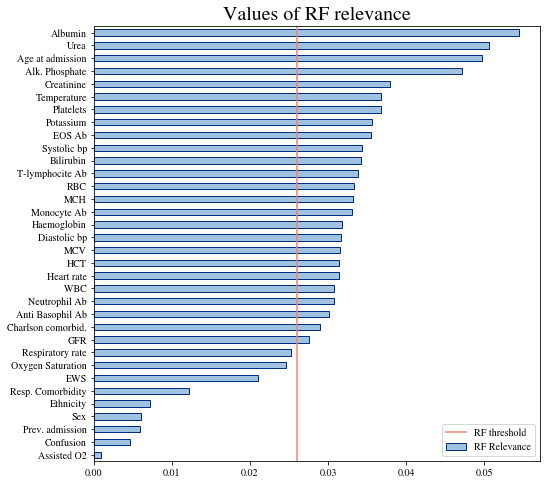

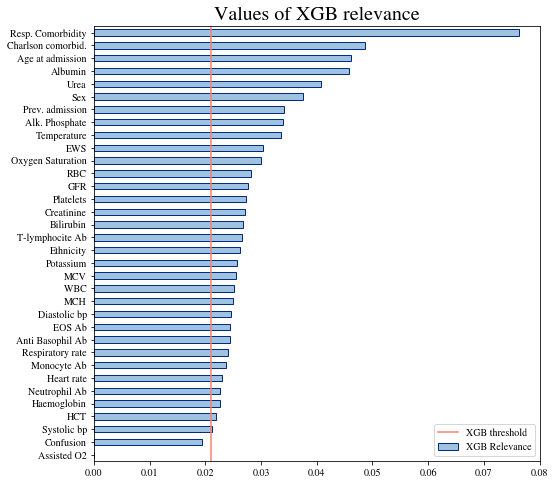

In [57]:
#row['import_DT'].sort_values(ascending = True).plot.barh(figsize=(8, 10))
#plt.axvline(x = 0.026, color = 'r', linestyle = '-')
#plt.savefig('Feature_selection_DT.png', transparent = True, bbox_inches = "tight")
#plt.show()

row_['import_RF'].sort_values(ascending = True).plot.barh(figsize=(8, 8), label = "RF Relevance", color='#9fc2e0', 
                                                         edgecolor='#002D82')
ordered_label = [dict_labels[feat] for feat in row_['import_RF'].sort_values(ascending = True).index]

plt.axvline(x = 0.026, linestyle = '-', label = "RF threshold", color = '#FA8072')
plt.legend()
plt.yticks(range(len(row_['import_RF'].sort_values(ascending = True).index)), ordered_label)
plt.title('Values of RF relevance', fontsize = 20)
#plt.savefig('Feature_selection_RF.png', transparent = True, bbox_inches = "tight")
plt.show()

row_['import_XGB'].sort_values(ascending = True).plot.barh(figsize=(8, 8), label = "XGB Relevance", color='#9fc2e0', 
                                                          edgecolor='#002D82')
ordered_label = [dict_labels[feat] for feat in row_['import_XGB'].sort_values(ascending = True).index]
plt.yticks(range(len(row_['import_XGB'].sort_values(ascending = True).index)), ordered_label)
plt.axvline(x = 0.021, linestyle = '-', label = "XGB threshold", color = '#FA8072')
plt.legend()
plt.title('Values of XGB relevance', fontsize = 20)
#plt.savefig('Feature_selection_XGB.png', transparent = True, bbox_inches = "tight")
plt.show()